In [1]:
import numpy as np
import struct

In [2]:
!pip install pydicom 

In [3]:
import pydicom

In [4]:
url = "https://github.com/marcodebe/dicom-ecg-plot/blob/master/sample_files/anonymous_ecg.dcm?raw=true"

In [5]:
!curl -L {url} > anonymous_ecg.dcm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   151  100   151    0     0    151      0  0:00:01 --:--:--  0:00:01   386

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   162  100   162    0     0    162      0  0:00:01 --:--:--  0:00:01  158k

100  284k  100  284k    0     0   284k      0  0:00:01 --:--:--  0:00:01  284k


In [6]:
dataset = pydicom.dcmread("anonymous_ecg.dcm")

# 'anonymous_ecg.dcm' was taken from https://github.com/marcodebe/dicom-ecg-plot (see above)

### 'dataset' contains ECG waves for a single individual, as far as we know here. We'll treat it as such.
### The DICOM format, seems to be flexible, hierarchical, binary format. It is mostly used for medical imaging, but can also be used, as in this example for ECG. The format encourages to include metadata about the packing of the data and additional details, for example, the identification of the patient.
### Having loaded the file with the 'pydicom' package, we can print the content and access individual pieces of information.

In [7]:
print(str(dataset)[:800])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.20029.40.20130125105919.5407.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.76.13.1.1.1.1
(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20130125'
(0008, 0013) Instance Creation Time              TM: 


In [8]:
dataset.file_meta

(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: 12-lead ECG Waveform Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.20029.40.20130125105919.5407.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.76.13.1.1.1.1
(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'

In [9]:
dataset.file_meta[(0x0002, 0x0013)]

(0002, 0013) Implementation Version Name         SH: 'AISDWAM40'

In [10]:
dataset[0x0008, 0x0005]  # note, keys are hexadecimals

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'

In [11]:
dataset[0x0008, 0x0005].value

'ISO_IR 100'

In [12]:
dataset.SpecificCharacterSet  # here we access the same entry by name

'ISO_IR 100'

In [13]:
dataset.WaveformSequence  # this entry is getting us closer to the actual readings

<Sequence, length 2>

### In 'dataset.WaveformSequence' there are two sequences. It seems that the first is x12 readings of ECG (12 channels), while the second is x12 averaging of the previous readings (after proper alignment). This is the interpretation that we follow bellow.
### We first examine the first wave form sequence.

In [14]:
# adapting code from https://github.com/marcodebe/dicom-ecg-plot

sequence_item = dataset.WaveformSequence[0]

assert (sequence_item.WaveformSampleInterpretation == 'SS')
assert (sequence_item.WaveformBitsAllocated == 16)

channel_definitions = sequence_item.ChannelDefinitionSequence
wavewform_data = sequence_item.WaveformData
channels_no = sequence_item.NumberOfWaveformChannels
samples = sequence_item.NumberOfWaveformSamples
sampling_frequency = sequence_item.SamplingFrequency
duration = samples / sampling_frequency

In [15]:
sequence_item.WaveformData[:30]

b'P\x00Z\x00\n\x00\xab\xff#\x002\x00(\x00\x0f\x00\xf6\xff\xec\xff\xc9\xff\xd8\xffA\x00U\x00\x14\x00'

In [16]:
channels_no

12

In [17]:
channel_definitions[0]

(003a, 0208)  Channel Source Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '5.6.3-9-1'
   (0008, 0102) Coding Scheme Designator            SH: 'SCPECG'
   (0008, 0103) Coding Scheme Version               SH: '1.3'
   (0008, 0104) Code Meaning                        LO: 'Lead I (Einthoven)'
   ---------
(003a, 0210) Channel Sensitivity                 DS: "1.25"
(003a, 0211)  Channel Sensitivity Units Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: 'uV'
   (0008, 0102) Coding Scheme Designator            SH: 'UCUM'
   (0008, 0103) Coding Scheme Version               SH: '1.4'
   (0008, 0104) Code Meaning                        LO: 'microvolt'
   ---------
(003a, 0212) Channel Sensitivity Correction Fact DS: "1.0"
(003a, 0213) Channel Baseline                    DS: "0.0"
(003a, 0215) Channel Sample Skew                 DS: "0.0"
(003a, 021a) Waveform Bits Stored                US: 16
(003a, 0220) Filter Low Frequenc

### The code below was adapted from https://github.com/marcodebe/dicom-ecg-plot. It shows how to unpack the bytes into Python floats. Those seem to be voltages from the sensors, that are then multiplied by some factors as is documented in the DICOM file. In the original example there was also code for a sort of smoothing, yet here we keep the readings raw (with the exception of multipling with factor).

In [18]:
# adapting code from https://github.com/marcodebe/dicom-ecg-plot

def signals():
    factor = np.zeros(channels_no) + 1
    baseln = np.zeros(channels_no)
    units = []
    for idx in range(channels_no):
        definition = channel_definitions[idx]

        assert (definition.WaveformBitsStored == 16)

        if definition.get('ChannelSensitivity'):
            factor[idx] = (
                float(definition.ChannelSensitivity) *
                float(definition.ChannelSensitivityCorrectionFactor)
            )

        if definition.get('ChannelBaseline'):
            baseln[idx] = float(definition.get('ChannelBaseline'))

        units.append(
            definition.ChannelSensitivityUnitsSequence[0].CodeValue
        )

    unpack_fmt = '<%dh' % (len(wavewform_data) / 2)
    unpacked_waveform_data = struct.unpack(unpack_fmt, wavewform_data)
    signals = np.asarray(
        unpacked_waveform_data,
        dtype=np.float32).reshape(
        samples,
        channels_no).transpose()

    for channel in range(channels_no):
        signals[channel] = (
            (signals[channel] + baseln[channel]) * factor[channel]
        )

    high = 40.0

    # conversion factor to obtain millivolts values
    millivolts = {'uV': 1000.0, 'mV': 1.0}

#     for i, signal in enumerate(signals):
#         signals[i] = butter_lowpass_filter(
#             np.asarray(signal),
#             high,
#             self.sampling_frequency,
#             order=2
#         ) / millivolts[units[i]]

    return signals

In [19]:
raw_signals_extracted = signals()

In [20]:
raw_signals_extracted

array([[ 100.  ,   81.25,   62.5 , ...,   25.  ,   21.25,   25.  ],
       [ 112.5 ,  106.25,  100.  , ...,  131.25,  137.5 ,  137.5 ],
       [  12.5 ,   25.  ,   37.5 , ...,  106.25,  116.25,  112.5 ],
       ...,
       [ -25.  ,  -25.  ,  -25.  , ..., -137.5 , -137.5 , -137.5 ],
       [ -68.75,  -75.  ,  -81.25, ..., -150.  , -150.  , -150.  ],
       [ -50.  ,  -50.  ,  -50.  , ..., -100.  , -106.25, -112.5 ]],
      dtype=float32)

In [21]:
raw_signals_extracted.shape

(12, 10000)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Here is one of the channels.

In [23]:
y = pd.Series(raw_signals_extracted[0, :])

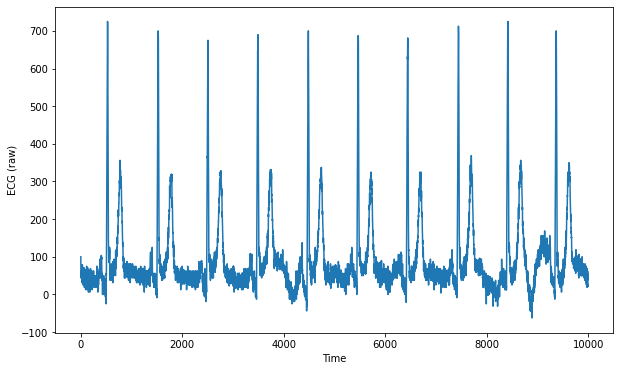

In [24]:
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(1, 1, 1)
y.plot(ax=ax1, label="y")
ax1.set(xlabel="Time", ylabel="ECG (raw)");

### And here we plot all the 12.

In [25]:
ys = [pd.Series(raw_signals_extracted[i, :]) for i in range(raw_signals_extracted.shape[0])]

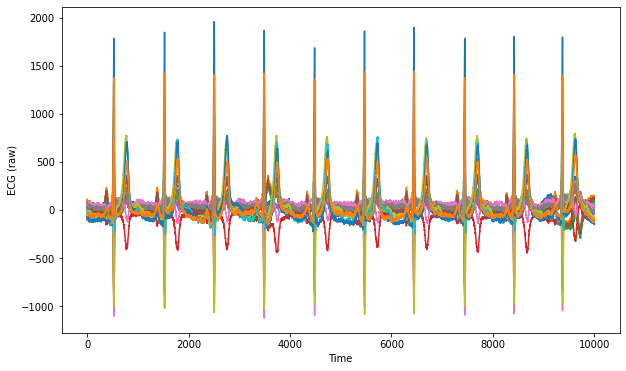

In [26]:
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(1, 1, 1)
for i, y in enumerate(ys):
    y.plot(ax=ax1, label=f'{i}')
ax1.set(xlabel="Time", ylabel="ECG (raw)");

## Wrapping above and showing how to create a 3d numpy array (actually 2)
### Note that we have 1 individual, two sequences, 12 channels in each sequence, yet of different nature (and length) among the sequences. We have decided here to have two separate 3d arrays, one for the first sequence, and another for the second sequence. The 3d arrays shall have 1 instance, and 12 variables (one per channel). The first 3d array shall have 10000 timepoints per variable, and the second, 1200 timepoints per variable.

In [27]:
from sktime.utils.data_container import from_3d_numpy_to_nested

In [28]:
def DICOM_dataset_to_dataframe(dataset):
    sequences = []
    for i, sequence_item in enumerate(dataset.WaveformSequence):
        assert (sequence_item.WaveformSampleInterpretation == 'SS')
        assert (sequence_item.WaveformBitsAllocated == 16)

        channel_definitions = sequence_item.ChannelDefinitionSequence
        wavewform_data = sequence_item.WaveformData
        channels_no = sequence_item.NumberOfWaveformChannels
        samples = sequence_item.NumberOfWaveformSamples
        sampling_frequency = sequence_item.SamplingFrequency
        duration = samples / sampling_frequency
        
        def signals():
            factor = np.zeros(channels_no) + 1
            baseln = np.zeros(channels_no)
            units = []
            for idx in range(channels_no):
                definition = channel_definitions[idx]

                assert (definition.WaveformBitsStored == 16)

                if definition.get('ChannelSensitivity'):
                    factor[idx] = (
                        float(definition.ChannelSensitivity) *
                        float(definition.ChannelSensitivityCorrectionFactor)
                    )

                if definition.get('ChannelBaseline'):
                    baseln[idx] = float(definition.get('ChannelBaseline'))

                units.append(
                    definition.ChannelSensitivityUnitsSequence[0].CodeValue
                )

            unpack_fmt = '<%dh' % (len(wavewform_data) / 2)
            unpacked_waveform_data = struct.unpack(unpack_fmt, wavewform_data)
            signals = np.asarray(
                unpacked_waveform_data,
                dtype=np.float32).reshape(
                samples,
                channels_no).transpose()

            for channel in range(channels_no):
                signals[channel] = (
                    (signals[channel] + baseln[channel]) * factor[channel]
                )
            
            return signals
        
        raw_signals_extracted = signals()
        
        # let's add a dimention (instance, as we have here one individual)
        
        dim_added = raw_signals_extracted[np.newaxis]
        
        sequence_as_expected_by_sktime = from_3d_numpy_to_nested(dim_added)

        sequences.append(sequence_as_expected_by_sktime)
                
    return sequences

In [29]:
data = DICOM_dataset_to_dataframe(dataset)  # the function above returns a list

In [30]:
len(data)

2

In [31]:
data[0].shape

(1, 12)

In [32]:
data[0].columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9', 'var_10', 'var_11'],
      dtype='object')

In [33]:
data[1].shape

(1, 12)

In [34]:
data[1].columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9', 'var_10', 'var_11'],
      dtype='object')

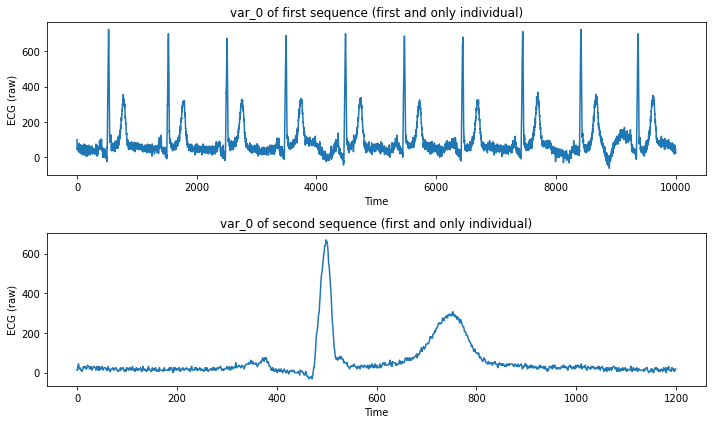

In [35]:
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(2, 1, 1)
data[0].iloc[0]['var_0'].plot(ax=ax1, title="var_0 of first sequence (first and only individual)")
ax1.set(xlabel="Time", ylabel="ECG (raw)")
ax2=plt.subplot(2, 1, 2)
data[1].iloc[0]['var_0'].plot(ax=ax2, title="var_0 of second sequence (first and only individual)")
ax2.set(xlabel="Time", ylabel="ECG (raw)")
plt.tight_layout();